In [1]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


In [2]:
%load_ext google.cloud.bigquery

In [3]:
%%bigquery df
select distinct requestUUID, client_query, context_query
from `etsy-sr-etl-prod.yzhang.attributed_instance_queries_1229_0104`
where context_query is not null
and context_query != client_query

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120108/120108 [00:02<00:00, 40954.29rows/s]


In [4]:
len(df.requestUUID.unique())

120039

+ Total number of requests from US, with at least 1 purchase: 407397
+ Among them, number of requests with contextual query not null: 351324
+ Among them, number of requests where client query != context query: 120039 (29.5%)

In [5]:
df.head()

,requestUUID,client_query,context_query
0,0005785f-3d06-488b-912f-641cb0429375,clock faces,clock face
1,0007fef5-16d5-4ec9-b84a-a5b954eefb36,physician assistant svg,physician assistant svg
2,000a6744-9965-41d5-8544-f5dbd5b565fa,bookmark tracker,bookmark track
3,000c7cdf-50cc-43e0-8cae-341a924c2654,plus size waist beads,plus size waist bead
4,000ee012-6d3a-448a-abb2-3d097462940e,primitive bunny rabbit patterns,primitive bunny rabbit pattern


+ Some raw query can correspond to 2 contextual query, why?

In [6]:
df.requestUUID.value_counts()

1172ba13-d3a1-44e6-b426-248764526a9a    2
9f631630-024f-4c55-9996-dfcea28efe7d    2
94c5b22d-381e-4b54-935a-14277af405cc    2
bee0808f-c15d-45a8-889e-3f9f1b3c38db    2
63edb957-76f0-41d5-9239-3b8b47d421bc    2
                                       ..
5a315073-4f7c-47d2-a229-722374c0cefb    1
5a2878a7-7560-4706-b62f-1f93643a9818    1
5a26efb1-ecde-4181-a5d1-49828480f420    1
5a22806d-6e99-41ba-af96-d472f5d65eae    1
fff9fa76-858c-4c44-8720-57f22229ea61    1
Name: requestUUID, Length: 120039, dtype: int64

In [7]:
df[df.requestUUID == "1172ba13-d3a1-44e6-b426-248764526a9a"]

,requestUUID,client_query,context_query
51393,1172ba13-d3a1-44e6-b426-248764526a9a,reyes magos png,wise men png
51394,1172ba13-d3a1-44e6-b426-248764526a9a,reyes magos png,reye mago png


In [8]:
df[df.requestUUID == "94c5b22d-381e-4b54-935a-14277af405cc"]

,requestUUID,client_query,context_query
112476,94c5b22d-381e-4b54-935a-14277af405cc,BUDA LASER,laser buddha
112477,94c5b22d-381e-4b54-935a-14277af405cc,BUDA LASER,buda laser


In [9]:
df[df.requestUUID == "63edb957-76f0-41d5-9239-3b8b47d421bc"]

,requestUUID,client_query,context_query
24231,63edb957-76f0-41d5-9239-3b8b47d421bc,raiders png,raider png
24232,63edb957-76f0-41d5-9239-3b8b47d421bc,raiders png,raider png image


In [16]:
import tensorflow as tf
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
# load NIR model
nir_base_path = "gs://etldata-prod-search-ranking-data-hkwv8r/data/shared/neural_ir/30d/large_voc_huge_hidden_assym/models"
nir_date = "2024_01_14"
nir_model = tf.saved_model.load(f"{nir_base_path}/{nir_date}/training_dir/checkpoints/saved_model")

In [12]:
nir_model.signatures

_SignatureMap({'embed_queries': <ConcreteFunction signature_wrapper(tf_examples) at 0x1760F3940>, 'embed_raw_queries': <ConcreteFunction signature_wrapper(queries) at 0x1769235E0>, 'embed_raw_listings': <ConcreteFunction signature_wrapper(tags, taxonomy_paths, titles) at 0x176C20AF0>, 'embed_raw_queries_loc': <ConcreteFunction signature_wrapper(countries, languages, queries) at 0x17693CF40>, 'embed_listings': <ConcreteFunction signature_wrapper(tf_examples) at 0x1769F2100>})

In [21]:
embed_dist_stats = []
cosine_sim_stats = []

for i in tqdm(range(df.shape[0])):
    context_query = df.context_query[i]
    client_query = df.client_query[i]
    
    context_query_tensor = tf.expand_dims(
        tf.convert_to_tensor(context_query, dtype=tf.string), 0
    )
    client_query_tensor = tf.expand_dims(
        tf.convert_to_tensor(client_query, dtype=tf.string), 0
    )
    
    context_embedding = nir_model.signatures["embed_raw_queries"](context_query_tensor)
    context_embedding = context_embedding["embedding"]
    client_embedding = nir_model.signatures["embed_raw_queries"](client_query_tensor)
    client_embedding = client_embedding["embedding"]
    
    embed_dist = np.sum(np.abs(context_embedding - client_embedding))
    embed_dist_stats.append(embed_dist)
    cosine_sim = np.dot(context_embedding, np.transpose(client_embedding)) / (norm(context_embedding) * norm(client_embedding))
    cosine_sim_stats.append(cosine_sim[0][0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120108/120108 [02:53<00:00, 692.70it/s]


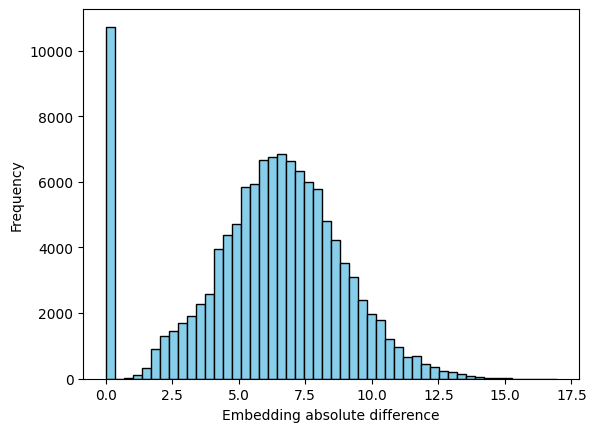

In [22]:
plt.hist(embed_dist_stats, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Embedding absolute difference')
plt.ylabel('Frequency')
plt.show()

In [23]:
print(np.mean(embed_dist_stats))
print(np.median(embed_dist_stats))

6.0892653
6.363255


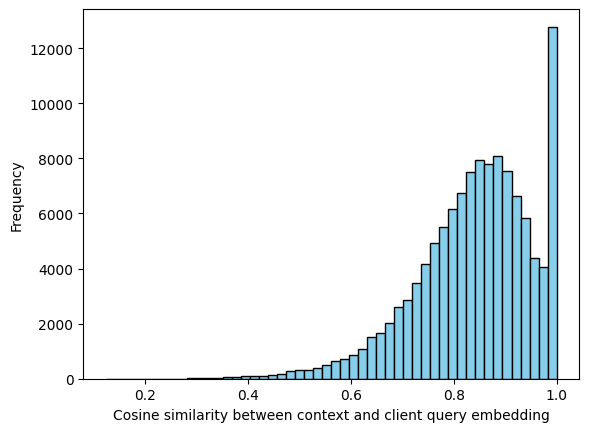

In [25]:
plt.hist(cosine_sim_stats, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Cosine similarity between context and client query embedding')
plt.ylabel('Frequency')
plt.show()

In [26]:
print(np.mean(cosine_sim_stats))
print(np.median(cosine_sim_stats))

0.83983177
0.8529854


In [28]:
len(cosine_sim_stats)

120108

In [42]:
embed_dist_stats_np = np.array(embed_dist_stats)
cosine_sim_stats_np = np.array(cosine_sim_stats)
big_diff = np.logical_and(embed_dist_stats_np >= 1.0, cosine_sim_stats_np <= 0.8)

In [43]:
df_big_diff = df[big_diff]

In [44]:
df_big_diff.shape

(38318, 3)

In [45]:
len(df_big_diff.requestUUID.unique())

38276

In [46]:
df_big_diff

,requestUUID,client_query,context_query
0,0005785f-3d06-488b-912f-641cb0429375,clock faces,clock face
2,000a6744-9965-41d5-8544-f5dbd5b565fa,bookmark tracker,bookmark track
8,001c18cb-64ca-4439-8302-d8abdffa33d8,Da Bears SVG,da bear svg
10,0028f05a-1b75-4e81-940b-4ee70181fccf,custom printed envelope,custom print envelope
11,003091e7-ec0c-478d-9699-68b9628fb787,Gaming PC ornament,game pc ornament
...,...,...,...
120086,ff9598a1-288b-4631-b460-0cd5c42eb50a,engraved trophy,engrave trophy
120095,ffae5e7d-f2ff-4f9d-9449-691a0d187104,no soliciting sign,no solicit sign
120096,ffb95d0c-eab6-40da-9ddd-bdd3a6660287,multistrand adjustable ring,multistrand adjust ring
120097,ffbba978-14ac-409f-a6a5-e0afcbded02f,disney dolls,disney doll
